In [1]:
import pickle
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import sys
sys.path.append('../')

### baseline

In [3]:
dir_in = '../out/20.0216 feat/reg_rf_boruta/' # location of the dm_data

In [221]:
#load data
dm_data = pickle.load(open('%s/dm_data.pkl' % dir_in,'rb'))

In [222]:
df_counts = pd.DataFrame([{'CERES':dm_data.df_crispr.shape[1],
                           'RNA-seq':dm_data.df_rnaseq.shape[1],
                           'CN':dm_data.df_cn.shape[1],
                           'Mut':dm_data.df_mut.shape[1],
                           'Lineage':dm_data.df_lineage.shape[1]}])

In [223]:
df_counts.T[0]

CERES      18333
CN         27639
Lineage       18
Mut         9065
RNA-seq    36759
Name: 0, dtype: int64

### synthetic lethal counts

In [224]:
df_featSummary = pd.read_csv(os.path.join(dir_in, 'anlyz_filtered', 'feat_summary.csv'))

In [225]:
df_featSummary.columns

Index(['target', 'score_rd', 'score_full', 'feature', 'score_ind',
       'feat_sources', 'feat_genes', 'feat_gene1', 'feat_source1',
       'feat_gene2', 'feat_source2', 'feat_gene3', 'feat_source3',
       'feat_gene4', 'feat_source4', 'feat_gene5', 'feat_source5',
       'feat_gene6', 'feat_source6', 'feat_gene7', 'feat_source7',
       'feat_gene8', 'feat_source8', 'feat_gene9', 'feat_source9',
       'feat_gene10', 'feat_source10', 'feats_n'],
      dtype='object')

In [226]:
df_counts = df_featSummary.groupby('feat_source1')['feat_source1'].count()
df_counts = df_counts.to_dict()
df_counts

{'CERES': 429, 'CN': 13, 'Mut': 3, 'RNA-seq': 81}

In [227]:
df_sl = pd.DataFrame([{'new_syn_lethal':df_counts['CERES'],
                       'classic_syn_lethal': sum([df_counts[k] for k in ['CN','Mut','RNA-seq']]) }])
df_sl

,classic_syn_lethal,new_syn_lethal
0,97,429


[[], Text(0.5,0,'Number of target genes')]

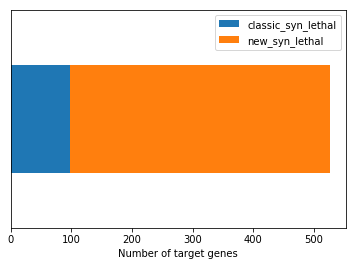

In [228]:
ax = df_sl.plot.barh(stacked=True)
plt.legend()
ax.set(xlabel='Number of target genes', yticks=[])

In [263]:
df_sl = df_sl.T.squeeze()

[Text(0,0.5,'Count of target genes'),
 [Text(0,0,'Classical synthetic lethal'), Text(0,0,'Others')],
 Text(0.5,0,'')]

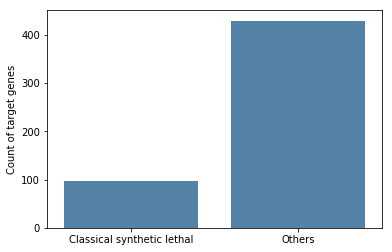

In [268]:
ax = sns.barplot(df_sl.index, df_sl.values, color='steelblue')
ax.set(xlabel='', 
       ylabel='Count of target genes',
       xticklabels=['Classical synthetic lethal', 'Others'])

### scores broken down by essentials

#### get gene dependency and classify them

In [62]:
df_genedep = pd.read_csv('../../%s/%s' % (dm_data.dir_datasets,dm_data.fname_gene_dependency), header=0, index_col=0)

In [67]:
df_genedep.columns = df_genedep.columns.str.extract('^(.*)\s').squeeze().values

In [68]:
df_genedep.head(2)

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
ACH-000004,0.001451,0.004520,0.102872,0.018067,0.008767,0.085647,0.000065,0.431382,0.000192,0.001974,...,0.060016,0.465022,NaN,NaN,0.000372,0.000517,0.374798,0.00022,0.000541,0.059707
ACH-000005,0.026104,0.001092,0.001859,0.002384,0.073250,0.175472,0.000745,0.528323,0.029178,0.011600,...,0.064166,0.252776,0.067042,0.037138,0.001671,0.027810,0.033134,0.01016,0.013513,0.103597


In [165]:
# get which ones are selective essential, and which ones are common essential, common nonessential
def classifyDep(x):
    if all(x>0.5):
        return 'common_essential'
    elif all(x<0.5):
        return 'common_nonessential'
    else:
        return 'selective_essential'
    
    
dep_class = df_genedep.apply(lambda x: classifyDep(x), axis=0)

In [166]:
dep_class.sample(6)

SLC46A3    selective_essential
NCL        selective_essential
CDC42      selective_essential
DBNDD1     selective_essential
EMILIN2    common_nonessential
PRIMA1     common_nonessential
dtype: object

In [167]:
dep_class.groupby(dep_class).count()

common_essential         424
common_nonessential     7322
selective_essential    10587
dtype: int64

#### merge with varExp

In [168]:
df_varExp = pd.read_csv(os.path.join(dir_in, 'anlyz_filtered', 'feat_summary_varExp_filtered.csv'))

In [169]:
df_varExp.head(3)

,feature,target,score_ind,score_rd,score_full,varExp_ofFull,varExp_ofRd,feat_idx,feat_gene,feat_source
0,FASN (2194) [CERES],ACACA,0.36564,0.3499,0.0524,6.97786,1.04498,1,FASN,CERES
1,SCD (6319) [CERES],ACACA,-0.08253,0.3499,0.0524,-1.57500,-0.23587,2,SCD,CERES
2,HSD17B12 (51144) [CERES],ACACA,0.00121,0.3499,0.0524,0.02309,0.00346,3,HSD17B12,CERES


In [170]:
df_tmp = df_varExp.merge(dep_class.to_frame(name='target_dep_class'), left_index=False, right_index=True, left_on='target')
df_tmp.head(3)

,feature,target,score_ind,score_rd,score_full,varExp_ofFull,varExp_ofRd,feat_idx,feat_gene,feat_source,target_dep_class
0,FASN (2194) [CERES],ACACA,0.36564,0.3499,0.0524,6.97786,1.04498,1,FASN,CERES,selective_essential
1,SCD (6319) [CERES],ACACA,-0.08253,0.3499,0.0524,-1.57500,-0.23587,2,SCD,CERES,selective_essential
2,HSD17B12 (51144) [CERES],ACACA,0.00121,0.3499,0.0524,0.02309,0.00346,3,HSD17B12,CERES,selective_essential


In [171]:
df_rd = df_tmp.groupby('target')[['score_rd', 'target_dep_class']].first()
df = pd.concat([pd.DataFrame({'score':df_rd.score_rd, 
                              'label':'multivariate', 
                              'target_dep_class':df_rd.target_dep_class}),
                pd.DataFrame({'score':df_varExp.score_ind, 
                              'label':'univariate',
                              'target_dep_class':df_tmp.target_dep_class})
               ])
df.head(3)

,score,label,target_dep_class
ACACA,0.34990,multivariate,selective_essential
ACLY,0.39931,multivariate,selective_essential
ACO2,0.39965,multivariate,selective_essential


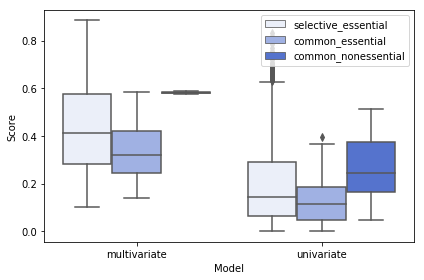

In [172]:
plt.figure()
ax = sns.boxplot(x='label',y='score',data=df.loc[df.score>0,:], color='royalblue', hue='target_dep_class')
ax.set(xlabel='Model', ylabel='Score')
plt.legend(loc='upper right')
plt.tight_layout()

### synthetic lethal counts (with merge)

In [173]:
df_featSummary = pd.read_csv(os.path.join(dir_in, 'anlyz_filtered', 'feat_summary.csv'))
df_featSummary.head(3)

,target,score_rd,score_full,feature,score_ind,feat_sources,feat_genes,feat_gene1,feat_source1,feat_gene2,...,feat_source6,feat_gene7,feat_source7,feat_gene8,feat_source8,feat_gene9,feat_source9,feat_gene10,feat_source10,feats_n
0,ACACA,0.34990,0.05240,"FASN (2194) [CERES],HSD17B12 (51144) [CERES],A...","0.366,0.001,0.039","['CERES', 'CERES', 'CERES']","['FASN', 'HSD17B12', 'ALG6']",FASN,CERES,HSD17B12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,ACLY,0.39931,0.07137,"FASN (2194) [CERES],ACSS1 (ENSG00000154930) [R...","0.242,0.14,0.118","['CERES', 'RNA-seq', 'CERES']","['FASN', 'ACSS1', 'ACACA']",FASN,CERES,ACSS1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2,ACO2,0.39965,0.11507,"ADSL (158) [CERES],IDH3A (3419) [CERES],SOD2 (...","0.172,0.078,0.15,0.153,0.194,0.016,0.018,0.116...","['CERES', 'CERES', 'CERES', 'CERES', 'CERES', ...","['ADSL', 'IDH3A', 'SOD2', 'GMPS', 'TFRC', 'SDH...",ADSL,CERES,IDH3A,...,CERES,ADAM12,RNA-seq,ATIC,CERES,PLOD2,RNA-seq,NaN,NaN,9


In [174]:
df_tmp = df_featSummary.merge(dep_class.to_frame(name='target_dep_class'), left_on='target', left_index=False, right_index=True)
df_tmp.head(3)

,target,score_rd,score_full,feature,score_ind,feat_sources,feat_genes,feat_gene1,feat_source1,feat_gene2,...,feat_gene7,feat_source7,feat_gene8,feat_source8,feat_gene9,feat_source9,feat_gene10,feat_source10,feats_n,target_dep_class
0,ACACA,0.34990,0.05240,"FASN (2194) [CERES],HSD17B12 (51144) [CERES],A...","0.366,0.001,0.039","['CERES', 'CERES', 'CERES']","['FASN', 'HSD17B12', 'ALG6']",FASN,CERES,HSD17B12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,selective_essential
1,ACLY,0.39931,0.07137,"FASN (2194) [CERES],ACSS1 (ENSG00000154930) [R...","0.242,0.14,0.118","['CERES', 'RNA-seq', 'CERES']","['FASN', 'ACSS1', 'ACACA']",FASN,CERES,ACSS1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,selective_essential
2,ACO2,0.39965,0.11507,"ADSL (158) [CERES],IDH3A (3419) [CERES],SOD2 (...","0.172,0.078,0.15,0.153,0.194,0.016,0.018,0.116...","['CERES', 'CERES', 'CERES', 'CERES', 'CERES', ...","['ADSL', 'IDH3A', 'SOD2', 'GMPS', 'TFRC', 'SDH...",ADSL,CERES,IDH3A,...,ADAM12,RNA-seq,ATIC,CERES,PLOD2,RNA-seq,NaN,NaN,9,selective_essential


In [188]:
df_counts_all = df_tmp.groupby('feat_source1')['feat_source1'].count()
df_counts_all.index = [('all', v) for v in df_counts_all.index.values]

In [189]:
df_counts = df_tmp.groupby(['target_dep_class', 'feat_source1'])['feat_source1'].count()
df_counts

target_dep_class     feat_source1
common_essential     CERES            21
                     CN                1
                     RNA-seq           1
common_nonessential  CERES             2
selective_essential  CERES           406
                     CN               12
                     Mut               3
                     RNA-seq          80
Name: feat_source1, dtype: int64

In [190]:
df_counts_all = pd.concat([df_counts,df_counts_all])
df_counts_all

target_dep_class     feat_source1
common_essential     CERES            21
                     CN                1
                     RNA-seq           1
common_nonessential  CERES             2
selective_essential  CERES           406
                     CN               12
                     Mut               3
                     RNA-seq          80
all                  CERES           429
                     CN               13
                     Mut               3
                     RNA-seq          81
Name: feat_source1, dtype: int64

In [209]:
df_counts_sel = df_counts_all.loc[[n in ['all', 'selective_essential'] for n in df_counts_all.index.get_level_values('target_dep_class')],:]

In [210]:
df_counts_sel.unstack(level=-1)

feat_source1,CERES,CN,Mut,RNA-seq
target_dep_class,,,,
selective_essential,406,12,3,80
all,429,13,3,81


[Text(0,0.5,''), Text(0.5,0,'Count')]

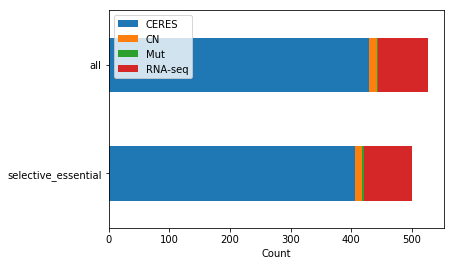

In [216]:
ax = df_counts_sel.unstack(level=-1).plot.barh(stacked=True)
ax.legend(title=None)
ax.set(xlabel='Count', ylabel='')